# MNIST with `TPUEstimator`
The purpose of this notebook is to convert the `Estimator` implementation of MNIST MLP in the notebook mnist-estimator.ipynb into an `TPUEstimator` implementation. With this done, we will have completed our ultimate quest to compare the runtime of MNIST on CPUs, GPUs, and TPUs, with the same code and datasets.

Most of this code will be ported from the last notebook, mnist-estimator.ipynb. In order to port it, we will make use of [this](https://cloud.google.com/tpu/docs/tutorials/migrating-to-tpuestimator-api) Google tutorial on how to port `Estimator` to `TPUEstimator`.

## Setup
First, we import the required libraries.

In [1]:
import os
import sys
import time
import tensorflow as tf
import numpy as np
import time
import gc

# Disable depreciation warnings and limit verbosity during training
try:
    from tensorflow.python.util import deprecation
    deprecation._PRINT_DEPRECATION_WARNINGS = False
except AttributeError:
    print("Import of warning suppression module failed")
    
tf.logging.set_verbosity(0)

Now we create some global variables which will define the learning process. They are set to be identical to the corresponding global variables in the `keras` implementation of MNIST in this repository.

In [2]:
NUM_CLASSES = 10
NUM_EPOCHS = 5
IMG_EDGE = 28
MODEL_DIR = 'gs://harrisgroup-ctpu/jtdinsmo/mnist/output/'
DATA_DIR = 'gs://harrisgroup-ctpu/jtdinsmo/mnist/data/'
TPU_NAME='jtdinsmo-tpu-2'
ZONE_NAME='us-central1-b'
PROJECT_NAME = 'harrisgroup-223921'
NUM_ITERATIONS = 50 # Number of iterations per TPU training loop
TRAIN_STEPS = 100000
EVALUATE_STEPS = 1000
INFERENCE_TIME_THRESHOLD = 10 # Seconds
NUM_SHARDS = 8 # Number of shards (TPU chips).
DEBUG = False # Set to True to prevent the TPU cluster from restarting, but this affects
    # train time, possibly inference time, and creates unusual errors such as 
    # UNHEALTHY_TENSORFLOW and sometimes it kills the kernel inexplicably.

We must download the MNIST dataset. We will download it in its orginal form, fitted neither to MLP format nor CNN format. We will reformat it for each of these implementations later. 

In [3]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns an np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns an np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


We also need a function to describe the behavior of the `TPUEstimator` during evaluation.

In [4]:
def metric_fn(labels, logits):
    accuracy = tf.metrics.accuracy(
        labels=labels, predictions=tf.argmax(logits, axis=1))
    return {"accuracy": accuracy}

def eval_input_fn(params):
    return (eval_data, eval_labels)
    
def train_input_fn(params):
    batch_size = params["batch_size"]
    train_data_dataset = tf.data.Dataset.from_tensor_slices(train_data)
    train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)
    single_train = tf.data.Dataset.zip((train_data_dataset, train_labels_dataset))
    dataset_train = single_train
    # Create epochs the dumb way: just keep adding shuffled versions of the same data onto the dataset
    for _ in range(NUM_EPOCHS-1):
        dataset_train = dataset_train.concatenate(single_train.shuffle(train_data.shape[0]))
    return dataset_train.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))

def purge_model_files():
    '''Used at the beginning of the code that runs MNIST for CNN and MLP implementations.
    If one of these two implementations is run after the other, it will throw hard-to-
    debug errors about how checkpoint files have been changed. All that is really happening
    is the program is trying to load checkpoints made with the previous model.'''
    
    if os.system("gsutil rm -r %s"%(MODEL_DIR)):
        print("Model directory could not be purged.")
    else:
        print("Model directory purged")

## Run
Now we will create a superclass &mdash; much like we did in the `keras` implementation of MNIST in this repository &mdash; which contains all of the functions common to both MLP and CNN implementations of MNIST. The methods of this superclass are described as follows:
- `_load` perfoms all the implementation-specific functions, such as determining the topology of the neural net, and reshaping the data.
- `model_fn` is a required argument of `tf.contrib.tpu.TPUEstimator.__init__` which describes the behavior of the `TPUEstimator`. 
- `_create` creates the `TPUEstimator`. Sometimes, it throws an `UNHEALTHY_TENSORFLOW` error if several models have already been created on the TPU cluster. In this case, stopping and restarting the cluster will solve the issue. We therefore stop and restart the TPU cluster every time `_create` is called, even when it doesn't throw the `UNHEALTHY_TENSORFLOW` for the sake of parity.
- `_train` will train the `TPUEstimator` and return the time per iteration it takes to do so, just as it did in the `keras` implementation of MNIST in this repository.
- `_predict` does the same but for inference. It will return the time it takes to do inference on the `TPUEstimator` per inference, where the batch size refers to the number of inferences to do in parallel.
- `_clean_up` executes several functions to avoid running out of memory. It may be that not all of the calls made in `_clean_up` have an effect, and thus the function could be trimmed, but debugging memory errors is a huge pain because they take so long to recreate, so I haven't trimmed it.
- `_main` is the function that the `tensorflow` app runs, which calls `_train` and `_predict` and gathers all the data into `self.train_times` and `self.inference_times`.
- `get_data` is the only "public" function &mdash; the only one which is called outside of the class. It calls `_main`.

In [5]:
batch_train_data = []
batch_inference_data = []

class MNIST:
    def __init__(self):
        self.learning_rate = None
        self.use_tpu = True
    
    # To be overridden
    def _load(self, features):
        '''
        Returns the model, the new features formatted in the way
        MLP or CNN needs them.
        '''
        return None, None
    
    # To be overridden
    def _load_batch_size_limits(self):
        self.start_power = None
        self.end_power = None
    
    def _get_batch_sizes(self):
        self._load_batch_size_limits()
        self.batch_sizes = []
        for i in range(self.start_power, self.end_power):
            self.batch_sizes += list(range(8**i, 8**(i+1), 8**i))
        self.batch_sizes += [8**self.end_power]
        
    def model_fn(self, features, labels, mode, params):
        del params# Unused
        image = features
        if isinstance(image, dict):
            image = features["image"]
        model, image = self._load(image)

        if mode == tf.estimator.ModeKeys.PREDICT:
            logits = model(image)
            predictions = {
                'class_ids': tf.argmax(logits, axis=1),
                'probabilities': tf.nn.softmax(logits),
            }
            return tf.contrib.tpu.TPUEstimatorSpec(mode, predictions=predictions)

        logits = model(image)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

        if mode == tf.estimator.ModeKeys.TRAIN:
            learning_rate = tf.train.exponential_decay(
                self.learning_rate,
                tf.train.get_global_step(),
                decay_steps=100000,
                decay_rate=0.96)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            if self.use_tpu:
                optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)
            return tf.contrib.tpu.TPUEstimatorSpec(
                mode=mode,
                loss=loss,
                train_op=optimizer.minimize(loss, tf.train.get_global_step()))

        if mode == tf.estimator.ModeKeys.EVAL:
            return tf.contrib.tpu.TPUEstimatorSpec(
                mode=mode, loss=loss, eval_metrics=(metric_fn, [labels, logits]))
    
    def _create(self, batch_size):
        # Restart the TPU cluster to avoid UNHEALTHY_TENSORFLOW
        if not DEBUG:# Don't restart on the first run
            print("Restarting TPU cluster, ", end='')
            
            os.system("echo; echo; free -m; echo; echo")# Print some memory stats
            
            os.system("gcloud compute tpus stop jtdinsmo-tpu-2 --zone us-central1-b")
            os.system("gcloud compute tpus start jtdinsmo-tpu-2 --zone us-central1-b")
            time.sleep(15)
                # Pause for a bit to allow the TPU clusters to finish running 
                # startup scripts if there are any.
            print("TPU cluster restarted")

        tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
            TPU_NAME,
            zone=ZONE_NAME,
            project=PROJECT_NAME)

        run_config = tf.contrib.tpu.RunConfig(
            cluster=tpu_cluster_resolver,
            model_dir=MODEL_DIR,
            session_config=tf.ConfigProto(
            allow_soft_placement=True, log_device_placement=True),
            tpu_config=tf.contrib.tpu.TPUConfig(NUM_ITERATIONS, NUM_SHARDS),)
        
        self.estimator = tf.contrib.tpu.TPUEstimator(
            model_fn=self.model_fn,
            use_tpu=self.use_tpu,
            train_batch_size=batch_size,
            eval_batch_size=batch_size,
            predict_batch_size=batch_size,
            params={"data_dir": DATA_DIR},
            config=run_config)

    def _train(self, batch_size):
        print("Training")
        evaluate_steps = train_data.shape[0] // batch_size
        train_steps = NUM_EPOCHS * evaluate_steps
        start_time = time.time()
        try:
            self.estimator.train(input_fn=train_input_fn, steps=train_steps)
        except tf.errors.OutOfRangeError:
            pass
        end_time = time.time()
        
        metrics = self.estimator.evaluate(input_fn=eval_input_fn, steps=evaluate_steps)
        print('Accuracy:', metrics['accuracy'], '\tLoss:', metrics['loss'],
              '\tTime:', end_time - start_time, 's')
        
        train_time = (end_time - start_time) / (NUM_EPOCHS * train_data.shape[0])
        return train_time
    
    def _predict(self, batch_size):
        inference_time_bare = 0
        inference_time_array = 0
        inference_num = 0
        start_inference = time.time()
        while True:
            random_dataset = np.random.rand(train_data.shape[0], IMG_EDGE**2).astype('float32')
            def predict_input_fn(params):
                batch_size = params["batch_size"]
                dataset_predict = tf.data.Dataset.from_tensor_slices(random_dataset)
                return dataset_predict.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))

            start_time = time.time()
            predictions = self.estimator.predict(predict_input_fn)
            inference_time_bare += time.time() - start_time
            
            labels = []
            for pred_dict in predictions:
                labels.append(pred_dict['class_ids'])
                #probability = pred_dict['probabilities'][class_id]
            labels = np.array(labels)
            end_time = time.time()
            inference_time_array += end_time - start_time
            inference_num += 1
            if end_time - start_inference > INFERENCE_TIME_THRESHOLD:
                # Do as many inferences as possible in INFERENCE_TIME_THRESHOLD seconds
                break
        return inference_time_bare / (train_data.shape[0] * inference_num), \
               inference_time_array / (train_data.shape[0] * inference_num), inference_num
    
    def _clean_up(self):
        tf.reset_default_graph()
        gc.collect()
    
    def _main(self, _):
        self.train_times = []
        self.inference_times_bare = []
        self.inference_times_array = []
        self._get_batch_sizes()
        for batch_size in self.batch_sizes:
            self._create(batch_size)
                            
            train_time = self._train(batch_size)
                
            inference_time_bare, inference_time_array, inference_num = self._predict(batch_size)
            print('\nBatch size:', batch_size, '\tTrain time:', train_time)
            print('Inference generator time', inference_time_bare, 's\tArray time', inference_time_array, 's (%s)'%inference_num)
            print('+'*120)
            self.train_times.append(train_time)
            self.inference_times_bare.append(inference_time_bare)
            self.inference_times_array.append(inference_time_array)
            
            self._clean_up()
            
    def get_data(self):
        try:
            tf.app.run(self._main)
        except SystemExit:
            # Prevent the program from exiting when done
            pass

With the superclass defined, we must now implement it for MLP and CNN versions of MNIST. For each, we define a class which contains the topology of the MNIST neural net (e.g., `ModelMLP`), and then we implement a subclass of the class `MNIST` we just defined which returns it (e.g., `MNIST_MLP`).

In [6]:
class ModelMLP(object):
    def __call__(self, inputs):
        net = tf.layers.dense(inputs, 512, activation=tf.nn.relu, name='dense1')
        net = tf.layers.dropout(net, rate=0.2, name='drop1')
        net = tf.layers.dense(net, 512, activation=tf.nn.relu, name='dense2')
        net = tf.layers.dropout(net, rate=0.2, name='drop2')
        net = tf.layers.dense(net, NUM_CLASSES, activation=tf.nn.softmax, name='dense3')
        return net
    
class MNIST_MLP(MNIST):
    def _load(self, features):
        images = tf.reshape(features, [-1, IMG_EDGE**2])
        self.learning_rate = 0.001# Learning rate from keras.optimizers.RMSprop
        return ModelMLP(), images
    def _load_batch_size_limits(self):
        self.start_power = 1
        self.end_power = 4

With the subclasses implemented, all we need to do is instantiate them and call `get_data` for both. This will train all the models and run all the inferences for all the batch sizes we need, with all possible combinations of machine type (CPU or GPU) and MNIST implementation (MLP or CNN).

In [7]:
purge_model_files()

print("MNIST MLP")
print()
mlp_tpu = MNIST_MLP()

print('+'*120)
mlp_tpu.get_data()

print()
print('+'*57, "DONE", '+'*57)

Model directory purged
MNIST MLP

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Restarting TPU cluster, TPU cluster restarted
Training
Accuracy: 0.7496 	Loss: 1.772153 	Time: 118.82840275764465 s

Batch size: 8 	Train time: 0.00043210328275507145
Inference generator time 4.551627419211648e-10 s	Array time 0.0009785069552334872 s (1)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Restarting TPU cluster, TPU cluster restarted
Training
Accuracy: 0.8842 	Loss: 1.659322 	Time: 119.17821264266968 s

Batch size: 16 	Train time: 0.000433375318700617
Inference generator time 5.288557572798296e-10 s	Array time 0.0006687042583118785 s (1)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Restarting TPU cluster, TPU cluster restarted
Training
Accuracy: 0.9016 	Loss: 1.6193688 	Time


Batch size: 4096 	Train time: 0.0007473641187494451
Inference generator time 5.071813409978693e-10 s	Array time 0.0002896387750452215 s (1)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++ DONE +++++++++++++++++++++++++++++++++++++++++++++++++++++++++


With MLP done, we will implement a subclass of `MNIST` using a CNN and run it.

In [8]:
class ModelCNN(object):
    def __call__(self, inputs):
        net = tf.layers.conv2d(inputs, 32, [5, 5], activation=tf.nn.relu, name='conv1')
        net = tf.layers.max_pooling2d(net, [2, 2], 2, name='pool1')
        net = tf.layers.conv2d(net, 64, [5, 5], activation=tf.nn.relu, name='conv2')
        net = tf.layers.max_pooling2d(net, [2, 2], 2, name='pool2')
        net = tf.layers.flatten(net, name='flat')
        net = tf.layers.dense(net, NUM_CLASSES, activation=None, name='fc1')
        return net
    
class MNIST_CNN(MNIST):
    def _load(self, features):
        images = tf.reshape(features, [-1, IMG_EDGE, IMG_EDGE, 1])
        self.learning_rate = 1.0# Learning rate from keras.optimizers.Adadelta
        return ModelCNN(), images
    def _load_batch_size_limits(self):
        self.start_power = 1
        self.end_power = 2

In [9]:
purge_model_files()

print("MNIST CNN")
print()
cnn_tpu = MNIST_CNN()

print('+'*100)
cnn_tpu.get_data()

print()
print('+'*47, "DONE", '+'*47)

Model directory purged
MNIST CNN

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Restarting TPU cluster, TPU cluster restarted
Training
Accuracy: 0.1028 	Loss: 2.3152256 	Time: 352.2660210132599 s

Batch size: 8 	Train time: 0.001280967349139127
Inference generator time 5.288557572798296e-10 s	Array time 0.0009754572651603005 s (1)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Restarting TPU cluster, TPU cluster restarted
Training
Accuracy: 0.1032 	Loss: 2.313959 	Time: 255.12705063819885 s

Batch size: 16 	Train time: 0.0009277347295934504
Inference generator time 5.071813409978693e-10 s	Array time 0.0006577627572146329 s (1)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Restarting TPU cluster, TPU cluster restarted
Training
Accuracy: 0.0982 	Loss: 2.3043504 	Time: 244.49290680885315 

## Graphing Data
Now we will graph the data we have collected above. First we import the `matplotlib` libraries.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

x_mlp = np.array(mlp_tpu.batch_sizes)
x_cnn = np.array(cnn_tpu.batch_sizes)

Then we plot the train time and inference times on CPUs and GPUs as a function of batch size. This is train time.

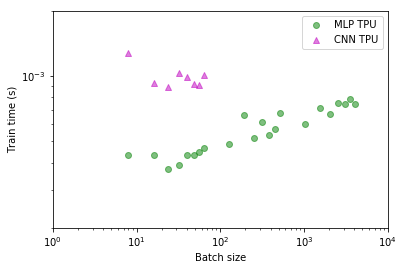

In [42]:
plt.scatter(x_mlp, mlp_tpu.train_times, c='g', alpha = 0.5)
plt.scatter(x_cnn, cnn_tpu.train_times, c='m', alpha = 0.5, marker='^')
plt.xlabel('Batch size')
plt.ylabel('Train time (s)')
plt.xscale('log')
plt.yscale('log')
plt.axis([1, 10000, 0.0002, 0.002])
plt.legend(['MLP TPU', 'CNN TPU'])
plt.show()

This is inference time.

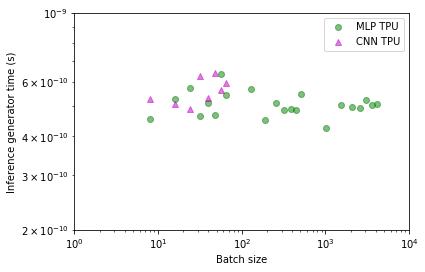

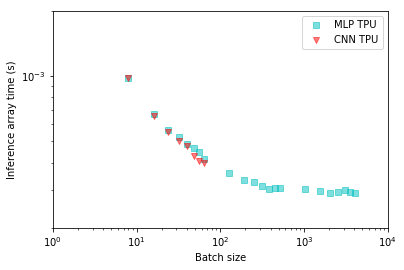

In [46]:
plt.scatter(x_mlp, mlp_tpu.inference_times_bare, c='g', alpha = 0.5)
plt.scatter(x_cnn, cnn_tpu.inference_times_bare, c='m', alpha = 0.5, marker='^')
plt.xlabel('Batch size')
plt.ylabel('Inference generator time (s)')
plt.xscale('log')
plt.yscale('log')
plt.axis([1, 10000, 0.0000000002, 0.000000001])
plt.legend(['MLP TPU', 'CNN TPU'])
plt.show()

plt.scatter(x_mlp, mlp_tpu.inference_times_array, c='c', alpha = 0.5, marker='s')
plt.scatter(x_cnn, cnn_tpu.inference_times_array, c='r', alpha = 0.5, marker='v')
plt.xlabel('Batch size')
plt.ylabel('Inference array time (s)')
plt.xscale('log')
plt.yscale('log')
plt.axis([1, 10000, 0.0002, 0.002])
plt.legend(['MLP TPU', 'CNN TPU'])
plt.show()

This concludes our experiment.

In [13]:
os.system("gcloud compute tpus stop jtdinsmo-tpu-2 --zone us-central1-b")

0